In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, norm

/Users/tomasz/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/tomasz/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


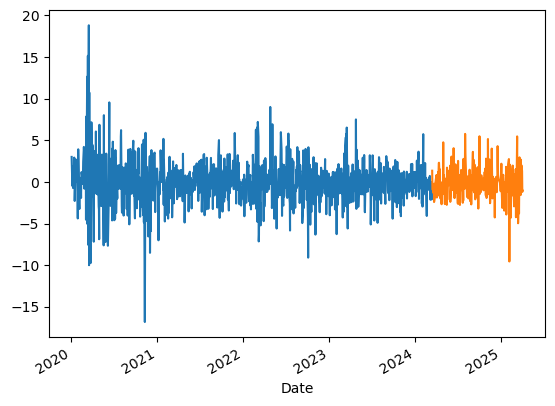

In [2]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san['log_return'] = np.log1p(san.iloc[:,0].pct_change())
san = san.log_return
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')
san.dropna(inplace=True)

ls = 100 * (1 - np.exp(san))
n = ls.size
train, test = ls.iloc[:int(n*0.8)], ls.iloc[int(n*0.8):]
train.plot()
test.plot();

# Historyczna metoda (zwykła)

## VaR(95%)

In [3]:
q95_empirical = train.quantile(0.95)
q95_empirical

3.8784682944285542

## VaR(99%)

In [4]:
q99_empirical = train.quantile(0.99)
q99_empirical

7.040686255858221

## Dane treningowe

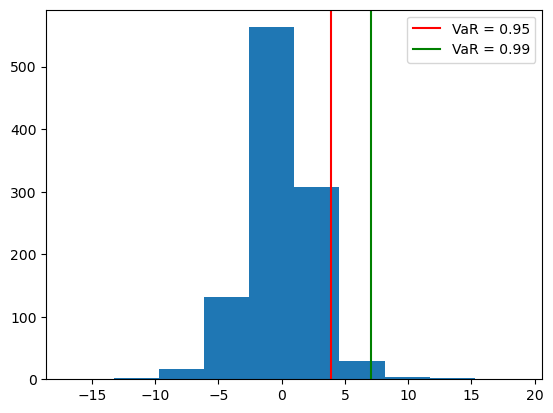

In [5]:
train.hist(grid=False)
plt.axvline(x = q95_empirical, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = q99_empirical, color = 'g', label = 'VaR = 0.99')
plt.legend();

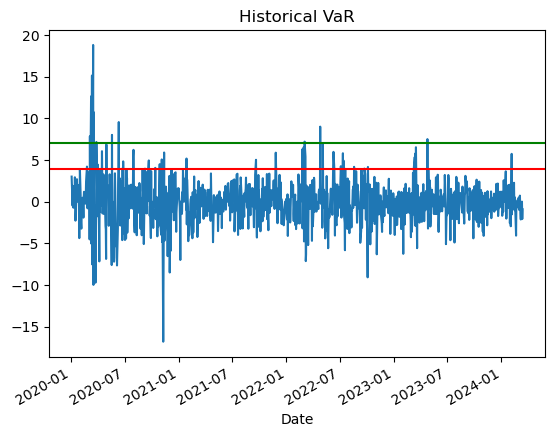

In [6]:
train.plot()
plt.axhline(y=q95_empirical, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=q99_empirical, color='g', linestyle='-', label = 'VaR = 0.99');
plt.legend
plt.title('Historical VaR');

## Dane testowe

## VaR(95%)

In [3]:
n_test = len(test)
cut_train = train.iloc[len(train) - n_test:]

In [23]:
quantiles95 = [cut_train.quantile(0.95)] + [0] * (n_test - 1)
exceptions95 = [0] * n_test
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles95[i] = data.quantile(0.95)   
    if test[i - 1] > quantiles95[i - 1]:
        exceptions95[i - 1] = 1

/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/4292436749.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/4292436749.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/4292436749.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

In [24]:
round(np.mean(exceptions95), 4)

0.0644

In [25]:
np.var(exceptions95)

0.06024735996326905

## VaR(99%)

In [10]:
quantiles99 = [cut_train.quantile(0.99)] + [0] * (n_test - 1)
exceptions99 = [0] * n_test
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles99[i] = data.quantile(0.99)   
    if test[i - 1] > quantiles99[i - 1]:
        exceptions99[i - 1] = 1

In [11]:
round(np.mean(exceptions99), 4)

0.0227

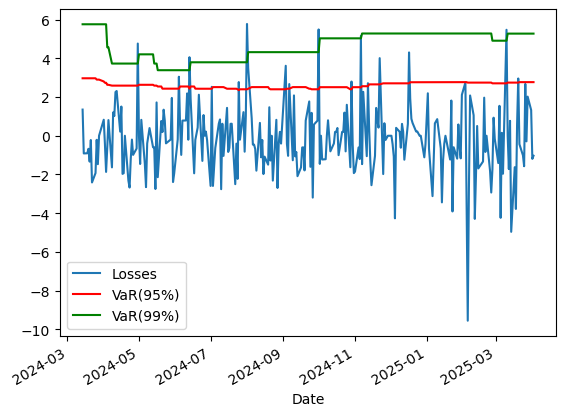

In [12]:
test.plot(label='Losses')
plt.plot(test.index, quantiles95, c='r', label='VaR(95%)')
plt.plot(test.index, quantiles99, c='g', label='VaR(99%)')
plt.legend();

# Historyczna metoda ważona

In [26]:
train_n = len(train)
lam = 0.97
wts_train = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, train_n + 1)] 
weights_dict_train = {'Returns':train[::-1], 'Weights': wts_train}
wts_returns_train = pd.DataFrame(weights_dict_train)
sorted_wts_train = wts_returns_train.sort_values(by='Returns')
sorted_wts_train['Cumulative'] = sorted_wts_train.Weights.cumsum()
sorted_wts_train

,Returns,Weights,Cumulative
Date,,,
2020-11-09,-16.822430,2.391147e-13,2.391147e-13
2020-03-17,-10.000021,1.570155e-15,2.406849e-13
2020-03-24,-9.734523,1.828453e-15,2.425133e-13
2022-10-04,-9.090906,5.031730e-07,5.031732e-07
2020-12-01,-8.510636,3.775985e-13,5.031736e-07
...,...,...,...
2020-06-11,9.558831,9.764239e-15,1.000000e+00
2020-03-18,10.743809,1.618716e-15,1.000000e+00
2020-03-09,12.647057,1.307895e-15,1.000000e+00


In [14]:
sorted_wts_train = sorted_wts_train.reset_index(drop=True)

## Var(95%)

In [27]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.95].Returns.idxmax()

Timestamp('2023-03-09 00:00:00')

In [16]:
sorted_wts_train.loc[905:906]

,Returns,Weights,Cumulative
905,2.261306,0.000013,0.946737
906,2.266999,0.016314,0.963051


In [17]:
xp95 = sorted_wts_train.loc[905:906, 'Cumulative'].values
fp95 = sorted_wts_train.loc[905:906, 'Returns'].values
VaR95_weighted = np.interp(0.95, xp95, fp95)
VaR95_weighted

2.2624445278535505

## VaR(99%)

In [18]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.99].Returns.idxmax()

1030

In [19]:
sorted_wts_train.loc[1030:1031]

,Returns,Weights,Cumulative
1030,5.462178,2.750423e-14,0.986346
1031,5.741619,1.358896e-02,0.999935


In [20]:
xp99 = sorted_wts_train.loc[1030:1031, 'Cumulative'].values
fp99 = sorted_wts_train.loc[1030:1031, 'Returns'].values
VaR99_weighted = np.interp(0.99, xp99, fp99)
VaR99_weighted

5.537325678138079

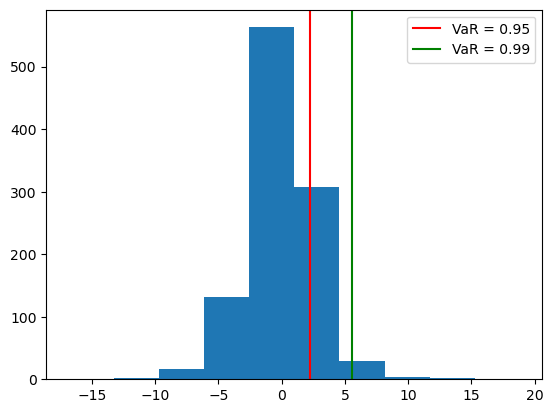

In [21]:
train.hist(grid=False)
plt.axvline(x = VaR95_weighted, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = VaR99_weighted, color = 'g', label = 'VaR = 0.99')
plt.legend();

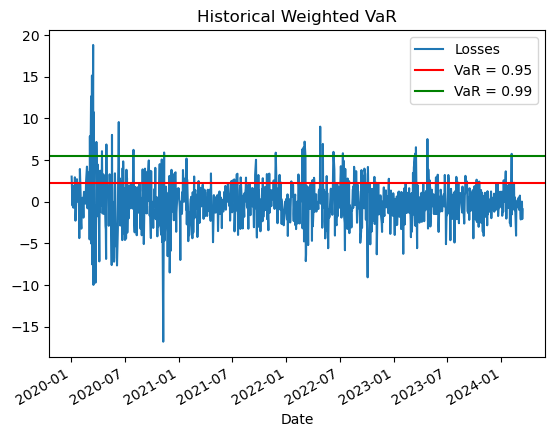

In [22]:
train.plot(label='Losses')
plt.axhline(y=VaR95_weighted, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=VaR99_weighted, color='g', linestyle='-', label = 'VaR = 0.99')
plt.legend()
plt.title('Historical Weighted VaR');

## Dane testowe

In [29]:
def historical_weighted_VaR(data, level):
    # wagi
    n = len(data)
    wts_data = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, n + 1)]
    # data frame
    weights_dict_data = {'Returns':data[::-1], 'Weights': wts_data}
    wts_returns_data = pd.DataFrame(weights_dict_data)
    # dystrybuanta
    sorted_wts_data = wts_returns_data.sort_values(by='Returns')
    sorted_wts_data['Cumulative'] = sorted_wts_data.Weights.cumsum()
    sorted_wts_data = sorted_wts_data.reset_index(drop=True)
    searched_index = sorted_wts_data[sorted_wts_data.Cumulative <= level].Returns.idxmax()
    xp_data = sorted_wts_data.loc[searched_index:searched_index + 1, 'Cumulative'].values
    fp_data = sorted_wts_data.loc[searched_index:searched_index + 1, 'Returns'].values
    # interpolacja
    return np.interp(level, xp_data, fp_data)

## VaR(95%)

In [30]:
quantiles95_weighted = [historical_weighted_VaR(cut_train, 0.95)] + [0] * (n_test - 1)
exceptions95_weighted = [0] * n_test

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles95_weighted[i - 1] = historical_weighted_VaR(data, 0.95)
    if test[i - 1] > quantiles95_weighted[i - 1]:
        exceptions95_weighted[i - 1] = 1

/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95_weighted[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95_weighted[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95_weighted[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i - 1] > quantiles95_weighted[i - 1]:
/var/folders/xn/vc8pmh6d66q1wx71kjbk95rh0000gn/T/ipykernel_39150/1205351289.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

In [31]:
round(np.mean(exceptions95_weighted), 4)

0.0682

In [33]:
np.var(exceptions95_weighted)

0.06353305785123967

## VaR(99%)

In [26]:
quantiles99_weighted = [historical_weighted_VaR(cut_train, 0.99)] + [0] * (n_test - 1)
exceptions99_weighted = [0] * n_test

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles99_weighted[i - 1] = historical_weighted_VaR(data, 0.99)
    if test[i - 1] > quantiles99_weighted[i - 1]:
        exceptions99_weighted[i - 1] = 1

In [27]:
round(np.mean(exceptions99_weighted), 4)

0.0152

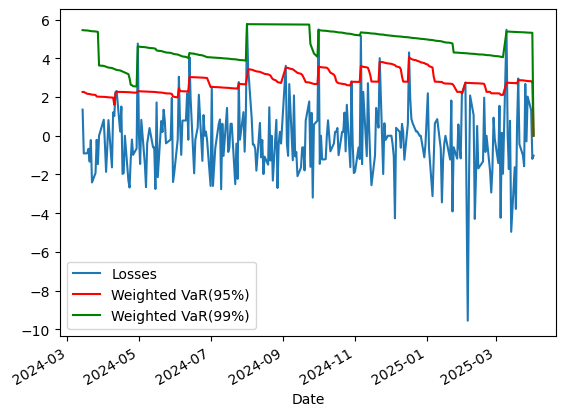

In [28]:
test.plot(label='Losses')
plt.plot(test.index, quantiles95_weighted, c='r', label='Weighted VaR(95%)')
plt.plot(test.index, quantiles99_weighted, c='g', label='Weighted VaR(99%)')
plt.legend();

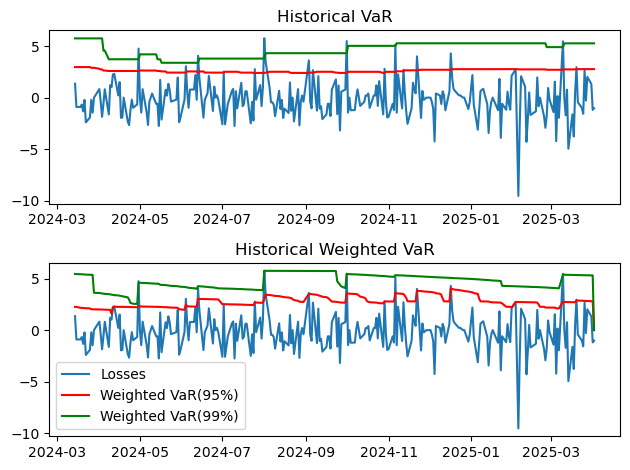

In [29]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title('Historical VaR')
ax1.plot(test, label='Losses')
ax1.plot(test.index, quantiles95, c='r', label='VaR(95%)')
ax1.plot(test.index, quantiles99, c='g', label='VaR(99%)')

ax2.set_title('Historical Weighted VaR')
ax2.plot(test, label='Losses')
ax2.plot(test.index, quantiles95_weighted, c='r', label='Weighted VaR(95%)')
ax2.plot(test.index, quantiles99_weighted, c='g', label='Weighted VaR(99%)')
ax2.legend()
plt.tight_layout();

# EVaR

## Historyczny EVaR
## EVaR(95%)

In [30]:
expectiles95 = [stats.expectile(cut_train, alpha=0.95)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles95[i] = stats.expectile(data, alpha=0.95)  

## EVaR(99%)

In [31]:
expectiles99 = [stats.expectile(cut_train, alpha=0.99)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles99[i] = stats.expectile(data, alpha=0.99)   

## Historycznie ważony EVaR

## EVaR(95%)

In [32]:
wts_evar = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, n_test + 1)][::-1]
expectiles95_weighted = [stats.expectile(cut_train, alpha=0.95, weights=wts_evar)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles95_weighted[i] = stats.expectile(data, alpha=0.95, weights=wts_evar)   

## EVaR(99%)

In [33]:
expectiles99_weighted = [stats.expectile(cut_train, alpha=0.99, weights=wts_evar)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles99_weighted[i] = stats.expectile(data, alpha=0.99, weights=wts_evar)   

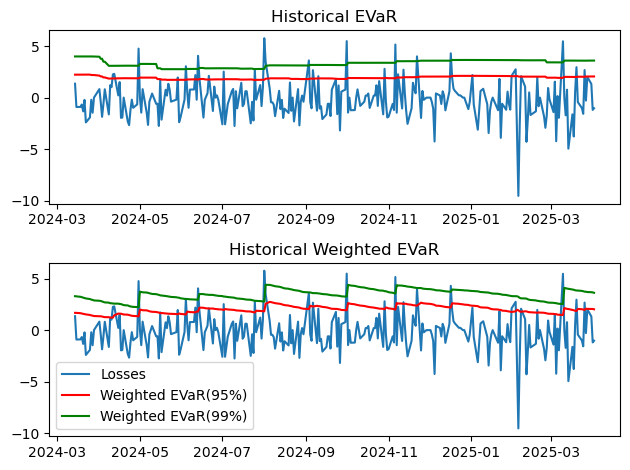

In [34]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title('Historical EVaR')
ax1.plot(test, label='Losses')
ax1.plot(test.index, expectiles95, c='r', label='EVaR(95%)')
ax1.plot(test.index, expectiles99, c='g', label='EVaR(99%)')

ax2.set_title('Historical Weighted EVaR')
ax2.plot(test, label='Losses')
ax2.plot(test.index, expectiles95_weighted, c='r', label='Weighted EVaR(95%)')
ax2.plot(test.index, expectiles99_weighted, c='g', label='Weighted EVaR(99%)')
ax2.legend()
plt.tight_layout();

# CVaR
## Historyczny CVaR

In [35]:
cvars_95 = np.zeros(n_test)
cvars_99 = np.zeros(n_test)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles99[i] = data.quantile(0.99) 
    cvars_95[i-1] = data[data > quantiles95[i]].mean()
    cvars_99[i-1] = data[data > quantiles99[i]].mean()

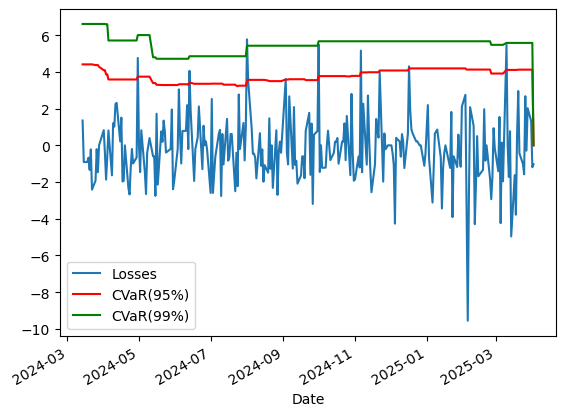

In [36]:
test.plot(label='Losses')
plt.plot(test.index, cvars_95, c='r', label='CVaR(95%)')
plt.plot(test.index, cvars_99, c='g', label='CVaR(99%)')
plt.legend();

In [14]:
def kupiec_test(exceptions, alpha):
    n = len(exceptions)
    x = np.sum(exceptions)  # liczba przekroczeń
    pi = x / n
    if pi == 0 or pi == 1:
        return np.nan, np.nan  # unika log(0)
    
    # log-likelihood ratio
    lr_uc = -2 * (x * np.log(alpha) + (n - x) * np.log(1 - alpha) -
                  (x * np.log(pi) + (n - x) * np.log(1 - pi)))
    p_value = stats.chi2.sf(lr_uc, df=1)
    decision = "reject H0" if p_value < 0.05 else "fail to reject H0"

    return decision, p_value

In [15]:
def christoffersen_test(exceptions):
    n00 = n01 = n10 = n11 = 0

    for i in range(1, len(exceptions)):
        prev, curr = exceptions[i-1], exceptions[i]
        if prev == 0 and curr == 0:
            n00 += 1
        elif prev == 0 and curr == 1:
            n01 += 1
        elif prev == 1 and curr == 0:
            n10 += 1
        elif prev == 1 and curr == 1:
            n11 += 1

    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi1 = (n01 + n11) / (n00 + n01 + n10 + n11)

    # log-likelihoods
    L0 = ((n01 + n11) * np.log(pi1) + 
          (n00 + n10) * np.log(1 - pi1)) if 0 < pi1 < 1 else -np.inf
    L1 = (n01 * np.log(pi01) + n00 * np.log(1 - pi01) +
          n11 * np.log(pi11) + n10 * np.log(1 - pi11)) if 0 < pi01 < 1 and 0 < pi11 < 1 else -np.inf

    lr_ind = -2 * (L0 - L1)
    p_value = stats.chi2.sf(lr_ind, df=1)
    decision = "reject H0" if p_value < 0.05 else "fail to reject H0"

    return decision, p_value

In [16]:
def berkowitz_test(data, cdf, alpha=0.05):
    """
    Perform the Berkowitz test for goodness of fit of estimated distributions to future returns.

    Parameters:
    - data: array-like, the data to test
    - cdf: list of callable, the CDFs for each sample
    - alpha: float, significance level

    Returns:
    - decision: str, "reject H0" or "fail to reject H0"
    - p_value: float, p-value of the test
    """
    n = len(data)
    u = np.zeros(n)

    for i in range(n):
        u[i] = cdf[i](data[i])

    # Transform to normal
    zs = norm.ppf(u)

    # Perform the Shapiro-Wilk test on the transformed data
    stat, p_value = shapiro(zs)
    decision = "reject H0" if p_value < alpha else "fail to reject H0"

    return decision, p_value

## Test Kupca

### VaR(95%)

In [40]:
kupiec_test(exceptions95, 0.05)

('fail to reject H0', 0.30327215194932244)

In [41]:
kupiec_test(exceptions95_weighted, 0.05)

('fail to reject H0', 0.1978688177050668)

### VaR(99%)

In [42]:
kupiec_test(exceptions99, 0.01)

('fail to reject H0', 0.07476641418030285)

In [43]:
kupiec_test(exceptions99_weighted, 0.01)

('fail to reject H0', 0.4343315769150874)

## Test Christoffersen

### VaR(95%)

In [44]:
christoffersen_test(exceptions95)

('fail to reject H0', 0.9186070140071344)

In [45]:
christoffersen_test(exceptions95_weighted)

('fail to reject H0', 0.49017022016865786)

### VaR(99%)

In [46]:
christoffersen_test(exceptions99)

('fail to reject H0', 1.0)

In [47]:
christoffersen_test(exceptions99_weighted)

('fail to reject H0', 1.0)

|  | VaR(95%) | VaR(99%) |
| :- | -: | :-: |
| Exceedance | 0.0644 | 0.0227
| Kupiec_pvalue | 0.3033 | 0.0748
| Kupiec_decision | 'fail to reject H0' | 'fail to reject H0'
| Christoffersen_pvalue | 0.9186 | 1.0
| Christoffersen_decision | 'fail to reject H0' | 'fail to reject H0'

|  | Weighted VaR(95%) | Weighted VaR(99%) |
| :- | -: | :-: |
| Exceedance | 0.0682 | 0.0152
| Kupiec_pvalue | 0.1979 | 0.4343
| Kupiec_decision | 'fail to reject H0' | 'fail to reject H0'
| Christoffersen_pvalue | 0.4902 | 1.0
| Christoffersen_decision | 'fail to reject H0' | 'fail to reject H0'

# Metoda parametryczna z wybranym rozkładem

## Rozkład normalny

In [48]:
mu, std = norm.fit(cut_train)
norm_quantiles95 = [norm.ppf(0.95, loc=mu, scale=std)] + [0] * (n_test - 1)
norm_cdf = [lambda x, mu=mu, std=std: norm(loc=mu, scale=std).cdf(x)] + [0] * (n_test - 1)
norm_exceptions95 = [0] * (n_test)
norm_evars_95 = np.zeros(n_test)
norm_cvars_95 = np.zeros(n_test)

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    mu, std = norm.fit(data)
    norm_quantiles95[i] = norm.ppf(0.95, loc=mu, scale=std)
    norm_cdf[i] = lambda x, mu=mu, std=std: norm(loc=mu, scale=std).cdf(x)
    if test[i - 1] > norm_quantiles95[i - 1]:
        norm_exceptions95[i - 1] = 1
#     norm_evars_95[i-1] = stats.expectile(0.95, )

In [49]:
kupiec_test(norm_exceptions95, 0.05)

('fail to reject H0', 0.30327215194932244)

In [50]:
christoffersen_test(norm_exceptions95)

('fail to reject H0', 0.9186070140071344)

In [51]:
mu, std = norm.fit(cut_train)
norm_quantiles99 = [norm.ppf(0.99, loc=mu, scale=std)] + [0] * (n_test - 1)
norm_exceptions99 = [0] * (n_test)
norm_evars_99 = np.zeros(n_test)
norm_cvars_99 = np.zeros(n_test)

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    mu, std = norm.fit(data)
    norm_quantiles95[i] = norm.ppf(0.99, loc=mu, scale=std)
    if test[i - 1] > norm_quantiles99[i - 1]:
        norm_exceptions99[i - 1] = 1
#     norm_evars[i-1] = stats.expectile()

In [52]:
kupiec_test(norm_exceptions99, 0.01)

('reject H0', 4.8306792569333415e-134)

In [53]:
christoffersen_test(norm_exceptions99)

('fail to reject H0', 0.8216088202295413)

In [54]:
berkowitz_test(test[1:n_test], norm_cdf)

('reject H0', 2.555845301879572e-06)

## Rozkład t-Studenta

In [55]:
df, loc, scale = stats.t.fit(cut_train)
t_quantiles95 = [stats.t.ppf(0.95, df=df, loc=loc, scale=scale)] + [0] * (n_test - 1)
t_cdf = [lambda x, df=df, loc=loc, scale=scale: stats.t(df=df, loc=loc, scale=scale).cdf(x)] + [0] * (n_test - 1)
t_exceptions95 = [0] * (n_test)

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    df, loc, scale = stats.t.fit(data)
    t_quantiles95[i] = stats.t.ppf(0.95, df=df, loc=loc, scale=scale)
    t_cdf[i] = lambda x, df=df, loc=loc, scale=scale: stats.t(df=df, loc=loc, scale=scale).cdf(x)
    if test[i - 1] > t_quantiles95[i - 1]:
        t_exceptions95[i - 1] = 1

In [56]:
kupiec_test(t_exceptions95, 0.05)

('fail to reject H0', 0.12324277333919556)

In [57]:
christoffersen_test(t_exceptions95)

('fail to reject H0', 0.7204553195710327)

In [58]:
df, loc, scale = stats.t.fit(cut_train)
t_quantiles99 = [stats.t.ppf(0.99, df=df, loc=loc, scale=scale)] + [0] * (n_test - 1)
t_exceptions99 = [0] * (n_test)

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    df, loc, scale = stats.t.fit(data)
    t_quantiles99[i] = stats.t.ppf(0.99, df=df, loc=loc, scale=scale)
    if test[i - 1] > t_quantiles99[i - 1]:
        t_exceptions99[i - 1] = 1

In [59]:
kupiec_test(t_exceptions99, 0.01)

('reject H0', 0.007583497401834982)

In [60]:
christoffersen_test(t_exceptions99)

('fail to reject H0', 1.0)

In [61]:
berkowitz_test(test[1:n_test], t_cdf)

('fail to reject H0', 0.2122581340407716)

## Genralized Extreme Value

In [62]:
shape, loc, scale = stats.genextreme.fit(cut_train)
genextreme_quantiles95 = [stats.genextreme.ppf(0.95, c=shape, loc=loc, scale=scale)] + [0] * (n_test - 1)
genextreme_cdf = [lambda x, c=shape, loc=loc, scale=scale: stats.genextreme(c=shape, loc=loc, scale=scale).cdf(x)] + [0] * (n_test - 1)
genextreme_exceptions95 = [0] * (n_test)

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    df, loc, scale = stats.genextreme.fit(data)
    genextreme_quantiles95[i] = stats.genextreme.ppf(0.95, c=shape, loc=loc, scale=scale)
    genextreme_cdf[i] = lambda x, c=shape, loc=loc, scale=scale: stats.genextreme(c=shape, loc=loc, scale=scale).cdf(x)
    if test[i - 1] > genextreme_quantiles95[i - 1]:
        genextreme_exceptions95[i - 1] = 1

In [63]:
kupiec_test(genextreme_exceptions95, 0.05)

('fail to reject H0', 0.8229092576382748)

# Metoda MC

In [5]:
t_var_95 = np.zeros(len(test))
t_var_99 = np.zeros(len(test))
t_evar_95 = np.zeros(len(test))
t_evar_99 = np.zeros(len(test))
t_cvar_95 = np.zeros(len(test))
t_cvar_99 = np.zeros(len(test))

MC = int(10e4)
for i in range(len(test)):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    df, loc, scale = stats.t.fit(data)
    t_rvs = stats.t.rvs(df=df, loc=loc, scale=scale, size=MC)
    t_var_95[i] = np.quantile(t_rvs, .95)
    t_var_99[i] = np.quantile(t_rvs, .99)
    t_evar_95[i] = stats.expectile(t_rvs, alpha=.95)
    t_evar_99[i] = stats.expectile(t_rvs, alpha=.99)
    t_cvar_95[i] = np.mean(t_rvs[t_rvs > t_var_95[i]])
    t_cvar_99[i] = np.mean(t_rvs[t_rvs > t_var_99[i]])
    
    

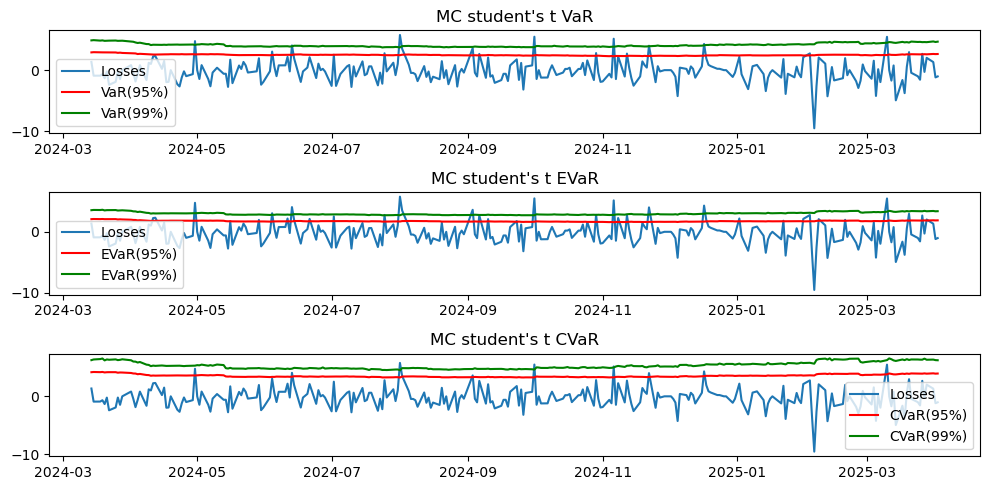

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 5))

ax1.set_title("MC student's t VaR")
ax1.plot(test, label='Losses')
ax1.plot(test.index, t_var_95, c='r', label='VaR(95%)')
ax1.plot(test.index, t_var_99, c='g', label='VaR(99%)')

ax2.set_title("MC student's t EVaR")
ax2.plot(test, label='Losses')
ax2.plot(test.index, t_evar_95, c='r', label='EVaR(95%)')
ax2.plot(test.index, t_evar_99, c='g', label='EVaR(99%)')

ax3.set_title("MC student's t CVaR")
ax3.plot(test, label='Losses')
ax3.plot(test.index, t_cvar_95, c='r', label='CVaR(95%)')
ax3.plot(test.index, t_cvar_99, c='g', label='CVaR(99%)')

ax2.legend()
ax1.legend()
ax3.legend()
plt.tight_layout();

In [9]:
exceedances_95 = (test.values > t_var_95).astype(int)
exceedances_99 = (test.values > t_var_99).astype(int)

# Procent przekroczeń:
exceedance_rate_95 = round(exceedances_95.mean(), 4)
exceedance_rate_99 =round(exceedances_99.mean(), 4)

In [22]:
exceedances_95.var()

0.06353305785123967

In [10]:
exceedance_rate_95

0.0682

In [11]:
exceedance_rate_99

0.0303

In [17]:
round(kupiec_test(list(exceedances_95), 0.95)[1], 4)

0.0

In [18]:
kupiec_test(list(exceedances_95), 0.95)

('reject H0', 2.6394116610294295e-294)

In [19]:
kupiec_test(list(exceedances_99), 0.99)

('reject H0', 0.0)

In [20]:
christoffersen_test(exceedances_95)

('fail to reject H0', 0.8173800214959784)

In [21]:
christoffersen_test(exceedances_99)

('fail to reject H0', 1.0)

|  | VaR(95%) | VaR(99%) |
| :- | -: | :-: |
| Exceedance | 0.0682 | 0.0303
| Kupiec_pvalue | 0.0 | 0.0
| Kupiec_decision | 'reject H0' | 'reject H0'
| Christoffersen_pvalue | 0.8174 | 1.0
| Christoffersen_decision | 'fail to reject H0' | 'fail to reject H0'

|  | Mean Exceedance | Var Exceedance |
| :- | -: | :-: |
| student's t rolling | 4.18% | 0.0651
| student's MC rolling | 6.82% | 0.0635
| Historical | 6.44% | 0.0602
| Weighted historical | 6.82% | 0.0635
| GARCH-ARMA filter | 4.92% | 0.0470
| GARCH-ARMA MC | 4.94% | 0.0472

In [34]:
pd.read_csv('dane/garch_filter_test.csv')

,VaR,Mean_Exceedance,Var_Exceedance,Kupiec_LRstat,Kupiec_pvalue,Kupiec_decision,Christoffersen_LRstat,Christoffersen_pvalue,Christoffersen_decision
0,VaR95,0.049430,0.047166,0.001808,0.966087,Fail to Reject H0,1.359855,0.506654,Fail to Reject H0
1,VaR99,0.022814,0.022378,3.201115,0.073588,Fail to Reject H0,3.482391,0.175311,Fail to Reject H0
2,EVaR95,0.098859,0.089426,10.419606,0.001247,Reject H0,10.500466,0.005246,Reject H0
3,EVaR99,0.034221,0.033176,9.561463,0.001987,Reject H0,10.201914,0.006091,Reject H0
4,CVaR95,0.015209,0.015035,9.110055,0.002542,Reject H0,9.234091,0.009882,Reject H0
5,CVaR99,0.000000,0.000000,1.336215,0.247702,Fail to Reject H0,1.343878,0.510717,Fail to Reject H0


In [ ]:
     VaR Mean_Exceedance Var_Exceedance
1  VaR95     0.049242424    0.046995622
2  VaR99     0.018939394    0.018651342
3 EVaR95     0.094696970    0.086055421
4 EVaR99     0.034090909    0.033053923
5 CVaR95     0.003787879    0.003787879
6 CVaR99     0.000000000    0.000000000

In [35]:
pd.read_csv('dane/MC_garch_test.csv')

,VaR,Mean_Exceedance,Var_Exceedance,Kupiec_LRstat,Kupiec_pvalue,Kupiec_decision,Christoffersen_LRstat,Christoffersen_pvalue,Christoffersen_decision
0,VaR95,0.049430,0.047166,0.001808,0.966087,Fail to Reject H0,1.359855,0.506654,Fail to Reject H0
1,VaR99,0.022814,0.022378,3.201115,0.073588,Fail to Reject H0,3.482391,0.175311,Fail to Reject H0
2,EVaR95,0.106464,0.095492,13.524479,0.000235,Reject H0,13.524503,0.001157,Reject H0
3,EVaR99,0.034221,0.033176,9.561463,0.001987,Reject H0,10.201914,0.006091,Reject H0
4,CVaR95,0.034221,0.033176,1.543004,0.214171,Fail to Reject H0,2.183455,0.335636,Fail to Reject H0
5,CVaR99,0.003802,0.003802,1.336215,0.247702,Fail to Reject H0,1.343878,0.510717,Fail to Reject H0


In [38]:
train.to_csv('train')

In [39]:
test.to_csv('test')